In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

import os

2024-10-24 19:45:18.061031: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 19:45:18.108701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 19:45:18.108746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 19:45:18.110310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 19:45:18.118869: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 19:45:18.119843: I tensorflow/core/platform/cpu_feature_guard.cc:1


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [22]:
model_names = [
    #"f_r_embed_input_d5_static_0.0005_28j",
    "f_r_penult_mult_d5_static_0.0005_Ag0",
    "f_r_penult_sum_d5_static_0.0005_370",
    "f_r_single_both_d5_static_0.0005_GTs",
    # "f_r_single_mult_d5_static_0.0005_JT1",
    # "f_r_single_sum_d5_static_0.0005_F8t",
    # "f_r_FiLM_reduced_d5_static_0.0005_9vG",
    "f_r_FiLM_full_d5_static_0.0005_XOr",
    "f_r_token_mult_d5_static_0.0005_eW4",
    "0.1107_f_r_token_sum_d5_static_0.0005_9I4",
    "f_r_single_token_d5_static_0.0005_lm6",
    "f_r_multi_token_d5_static_0.0005_RvL",
]

model_labels = [name.split('_r_')[1].split('_d5_')[0] for name in model_names]
model_labels = [
    "Penultimate Mult",
    "Penultimate Sum",
    "Simple Integration",
    # "simple mult",
    # "simple sum",
    # "FiLM reduced",
    "FiLM Integration",
    "Multiple Mult",
    "Multiple Sum",
    "Embed Single Token",
    "Embed Multi Token",
]

# adjust custom palette
custom_palette = {
    "Penultimate Mult"        : "#ff9f9b",
    "Penultimate Sum"         : "#ff9f9b",
    "Simple Integration"      : "#d0bbff",
    # "simple mult'           : "#ff9f9b",
    # "simple sum'            : "#a1c9f4",
    # "FiLM reduced'          : "#d0bbff",
    "FiLM Integration"        : "#d0bbff",
    "Multiple Mult"           : "#d0bbff",
    "Multiple Sum"            : "#d0bbff",
    "Embed Single Token"      : "#a1c9f4",
    "Embed Multi Token"       : "#a1c9f4",
}

# custom_palette = {
#     'penult_sum'    : "brown",
#     'single_both'   : "grey",
#     'single_mult'   : "grey",
#     'single_sum'    : "grey",
#     'FiLM_reduced'  : "green",
#     'FiLM_full'     : "green",
#     'token_mult'    : "orange",
#     'token_sum'     : "orange",
#     'single_token'  : "purple",
#     'multi_token'   : "purple",
# }


In [5]:
print(model_names[5])

model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_names[5],
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()


print(len(int_data.tensor_train_data))
print(len(int_data.tensor_val_data))

f_r_FiLM_full_d5_static_0.0005_XOr
Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6656      
                                                                 
 dense_1 (Dense)             multiple                  3328      
                                                                 
 dense_2 (Dense)             multiple                  657920    
                                                                 
 trans_block (TransBlock)    multiple                  524545    
                                                                 
 trans_block_1 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_2 (TransBlock)  multiple                  524545    
                                                                 
 trans_block_3

NameError: name 'int_data' is not defined

In [9]:
int_data = FragmentIonIntensityDataset.load_from_disk("/cmnfs/proj/prosit_astral/datasets/_dlomix_saved/full_dataset")

In [10]:
losses = []

eval_batches = [m for m in int_data.tensor_val_data.take(20)]

for model_name in model_names:

    model = keras.saving.load_model('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_name,
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
    
    pred = []
    true = []
    
    for j in range(0, len(eval_batches)):
    
        predictions = model.predict(eval_batches[j][0], verbose=0)
    
        pred += np.split(predictions,        predictions.shape[0], axis=0) 
        true += np.split(eval_batches[j][1], predictions.shape[0], axis=0) 
    
    pred = np.concatenate(pred, axis=0)
    true = np.concatenate(true, axis=0)
    
    print('Loss: ', tf.reduce_mean( masked_spectral_distance(true, pred) ))

    losses.append(masked_spectral_distance(true, pred))

print(losses)

Loss:  tf.Tensor(0.10798229, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10789535, shape=(), dtype=float32)
Loss:  tf.Tensor(0.102125846, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10307278, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10270822, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10502939, shape=(), dtype=float32)
Loss:  tf.Tensor(0.103084825, shape=(), dtype=float32)
Loss:  tf.Tensor(0.10349276, shape=(), dtype=float32)
[<tf.Tensor: shape=(20480,), dtype=float32, numpy=
array([0.01478939, 0.19360076, 0.11534242, ..., 0.04889799, 0.1917394 ,
       0.03055487], dtype=float32)>, <tf.Tensor: shape=(20480,), dtype=float32, numpy=
array([0.02740276, 0.13804853, 0.11117673, ..., 0.01366174, 0.19390047,
       0.03144513], dtype=float32)>, <tf.Tensor: shape=(20480,), dtype=float32, numpy=
array([0.01733022, 0.12754469, 0.10577754, ..., 0.03533625, 0.1864119 ,
       0.0325694 ], dtype=float32)>, <tf.Tensor: shape=(20480,), dtype=float32, numpy=
array([0.02843363, 0.13083836, 0.12347

In [13]:
import pandas as pd
import numpy as np

print(len(np.repeat(model_labels, len(losses[0]))))
print(len(tf.concat(losses, axis=0)))

for i in losses:
    print(len(i))


test = pd.DataFrame({
    'method': np.repeat(model_labels, len(losses[0])),
    'loss': 1 - tf.concat(losses, axis=0),
})

test.groupby('method')['loss'].median()

163840
163840
20480
20480
20480
20480
20480
20480
20480
20480


method
Embed Multi Token     0.923603
Embed Single Token    0.924157
FiLM Integration      0.924099
Multiple Mult         0.924230
Multiple Sum          0.922110
Penultimate Mult      0.919683
Penultimate Sum       0.919886
Simple Integration    0.925089
Name: loss, dtype: float32

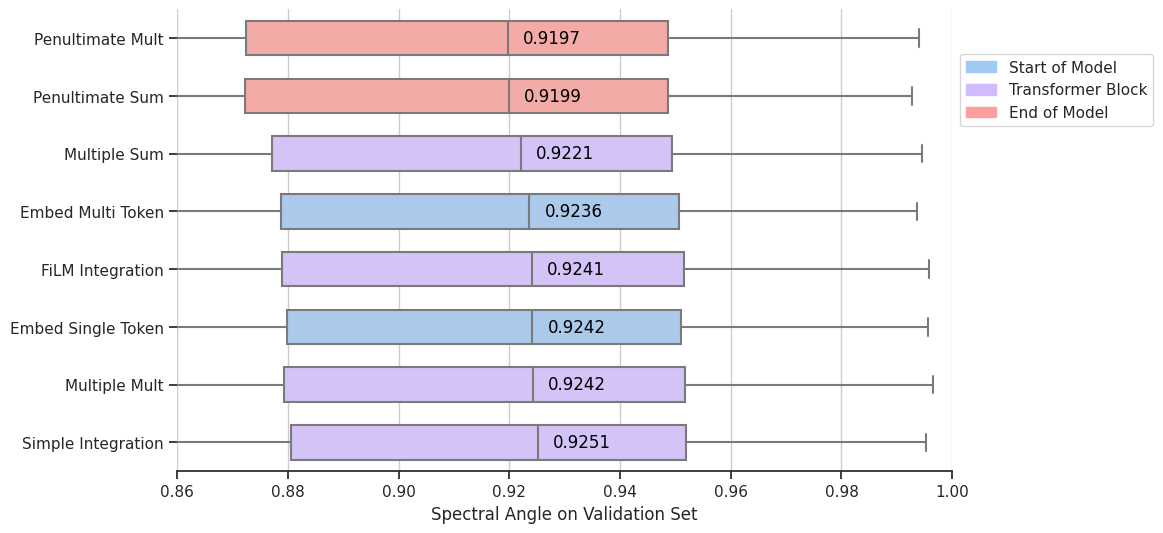

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis and set the plot size
f, ax = plt.subplots(figsize=(10, 6))  # Adjust the size here

ax.set_xlim(0.86, 1)

method_order = test.groupby('method')['loss'].median().sort_values().index

# sns.violinplot(
#     test, x="loss", y="method",
#     order=method_order, palette=custom_palette
# )

sns.boxplot(
   test, x="loss", y="method",
   order=method_order,  # Order y-axis by median loss
   whis=[0, 100], width=.6, palette=custom_palette
)

# Calculate and label the medians
medians = test.groupby('method')['loss'].median().reindex(method_order)

for i, method in enumerate(method_order):
    median_value = medians[method]
    ax.text(median_value+0.008, i, f'{median_value:.4f}', 
            va='center', ha='center', color='black')

# Add in points to show each observation
# sns.stripplot(test, x="loss", y="method", order=method_order, size=4, color=".3")

start_patch = mpatches.Patch(color="#a1c9f4", label='Start of Model')
block_patch = mpatches.Patch(color="#d0bbff", label='Transformer Block')
end_patch = mpatches.Patch(color="#ff9f9b", label='End of Model')

plt.legend(handles=[start_patch, block_patch, end_patch], bbox_to_anchor=(1, 0.92))

plt.xlabel('Spectral Angle on Validation Set')

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

plt.show()